In [1]:
!pip3 install numpy pandas matplotlib scipy
import os
import numpy as np
import pandas as pd
from scipy import stats
import re

Failed to execute process '/home/paul/git/ir-lab/.venv/bin/pip3'. Reason:
The file '/home/paul/git/ir-lab/.venv/bin/pip3' specified the interpreter '/home/paul/git/ir-lab-jena-leipzig-wise-2023-geometric-tortoise/.venv/bin/python', which is not an executable command.


In [2]:
if 'TIRA_DATASET_ID' not in os.environ:
    !pip3 install python-terrier tira==0.0.88
else:
    print('We are in the TIRA sandbox.')

Failed to execute process '/home/paul/git/ir-lab/.venv/bin/pip3'. Reason:
The file '/home/paul/git/ir-lab/.venv/bin/pip3' specified the interpreter '/home/paul/git/ir-lab-jena-leipzig-wise-2023-geometric-tortoise/.venv/bin/python', which is not an executable command.


In [3]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run

# this loads and starts pyterrier so that it also works in the TIRA
ensure_pyterrier_is_loaded()

# PyTerrier must be imported after the call to ensure_pyterrier_is_loaded in TIRA.
import pyterrier as pt

/home/paul/git/ir-lab/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTerrier 0.10.0 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Due to execution in TIRA, I have patched ir_datasets to always return the single input dataset mounted to the sandbox.
Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


### Herausfinden des Schwellwerts

In [4]:
df = pd.read_xml("topics-anonymized.xml")
df.head()

,number,title,description,narrative
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe..."
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...


In [5]:
df["length"] = df["title"].map(lambda x: len(x))
df["word_count"] = df["title"].map(lambda x: x.count(" ")+1)
df.head()

,number,title,description,narrative,length,word_count
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,71,12
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",27,4
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,25,4
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,18,3
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,13,3


array([[<Axes: title={'center': 'length'}>]], dtype=object)

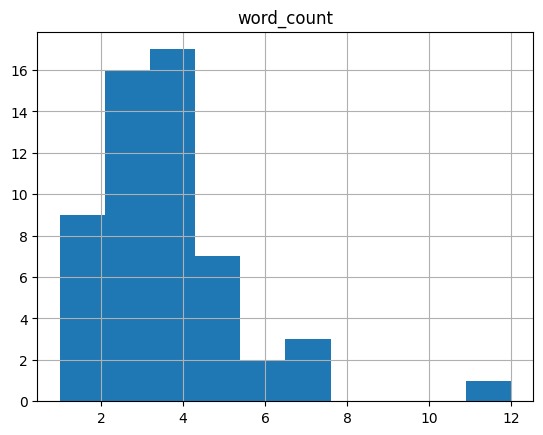

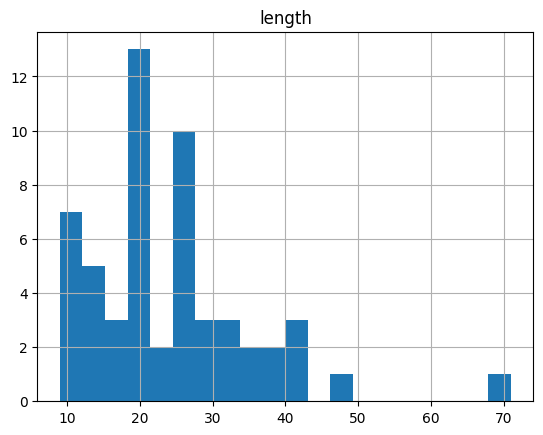

In [6]:
df.hist(column="word_count")
df.hist(column="length", bins=20)

In [7]:
median = df["word_count"].median()
groups_df = pd.DataFrame({f"median = {median}": ["below", "above"], 
                           "# topics with median not included": [len(df[df["word_count"] < median]), len(df[df["word_count"] > median])], 
                           "# topics with median included": [len(df[df["word_count"] <= median]), len(df[df["word_count"] >= median])]})
groups_df = groups_df.style.highlight_max("# topics with median not included", props="font-weight: bold").highlight_min("# topics with median included", props="font-weight: bold")
groups_df

,median = 4.0,# topics with median not included,# topics with median included
0,below,25,42
1,above,13,30


### Index bauen

In [8]:
data = pt.get_dataset('irds:ir-lab-jena-leipzig-wise-2023/validation-20231104-training')

Load ir_dataset "ir-lab-jena-leipzig-wise-2023/validation-20231104-training" from tira.


In [9]:
print('Build index:')
iter_indexer = pt.IterDictIndexer("/tmp/index", meta={'docno': 100}, verbose=True)
!rm -Rf /tmp/index
indexref = iter_indexer.index(data.get_corpus_iter())
print('Done. Index is created')

Build index:


No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents:   0%|          | 0/61307 [00:00<?, ?it/s]

No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents: 100%|██████████| 61307/61307 [00:32<00:00, 1908.34it/s]


Done. Index is created


### Unsere Retrieval Pipeline

In [10]:
bo1 = pt.rewrite.Bo1QueryExpansion(indexref, verbose=True)
rm3 = pt.rewrite.RM3(indexref, verbose=True)
bm25 = pt.BatchRetrieve(indexref, wmodel="BM25", verbose=True)
tf_idf = pt.BatchRetrieve(indexref, wmodel="TF_IDF", verbose=True)
non_qe_pipeline = tf_idf
qe_pipeline = tf_idf >> bo1 >> tf_idf

In [11]:
qe_test_queryDf = data.get_topics()[["qid","title"]].rename(columns={"title": "query"}).head()

qe_results = [ {"pipe": "bm25_bo1_r",    "df":   (bm25 >> bo1).transform(qe_test_queryDf) },
               {"pipe": "bm25_rm3_r",    "df":   (bm25 >> rm3).transform(qe_test_queryDf) },
               {"pipe": "tf_idf_bo1_r",  "df": (tf_idf >> bo1).transform(qe_test_queryDf) },
               {"pipe": "tf_idf_rm3_r",  "df": (tf_idf >> rm3).transform(qe_test_queryDf) } ]
df = qe_results[0]["df"][["qid", "query_0"]].rename(columns={"query_0": "query"})
for result in qe_results:
    result["df"].rename(columns={"query": result["pipe"]}, inplace=True)
    result["df"].drop(columns=["query_0"], inplace=True)
    df = df.merge(result["df"], on=["qid"])

for r in df.iterrows():
    print(f"""
    qid:          {r[1]["qid"]}
    query:        {r[1]["query"]}
    bm25_bo1_r:   {r[1]["bm25_bo1_r"]}
    bm25_rm3_r:   {r[1]["bm25_rm3_r"]}
    tf_idf_bo1_r: {r[1]["tf_idf_bo1_r"]}
    tf_idf_rm3_r: {r[1]["tf_idf_rm3_r"]}
    """)

No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


BR(BM25):  20%|██        | 1/5 [00:00<00:00,  7.79q/s]

Transformer: 100%|██████████| 5/5 [00:00<00:00, 331.98q/s]


    qid:          q072224
    query:        purchase money
    bm25_bo1_r:   applypipeline:off purchas^1.124916191 monei^1.171398406 buyer^0.114867291 seller^0.090024680 length^0.059362351 deposit^0.057799048 properti^0.052173303 cash^0.049139810 sale^0.041757400 estat^0.041346815
    bm25_rm3_r:   applypipeline:off purchas^0.300000012 buyer^0.060062546 agreement^0.028948911 estat^0.035443090 capit^0.036937352 gain^0.027703013 seller^0.058997158 levi^0.027703013 monei^0.300000012 deposit^0.036903422 taxat^0.046171684 launder^0.041129794
    tf_idf_bo1_r: applypipeline:off purchas^1.124916191 monei^1.171398406 buyer^0.114867291 seller^0.090024680 length^0.059362351 deposit^0.057799048 properti^0.052173303 cash^0.049139810 sale^0.041757400 estat^0.041346815
    tf_idf_rm3_r: applypipeline:off purchas^0.300000012 buyer^0.060062546 agreement^0.028948911 estat^0.035443090 capit^0.036937352 gain^0.027703013 seller^0.058997158 levi^0.027703013 monei^0.300000012 deposit^0.036903422 taxat^0.04

In [12]:
topics = data.get_topics()
topics.head()

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


,qid,text,title,query,description,narrative
0,q072224,purchase money,purchase money,purchase money,None,None
1,q072226,purchase used car,purchase used car,purchase used car,None,None
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None
3,q072240,adenovirus,adenovirus,adenovirus,None,None
4,q072242,Water softener,Water softener,water softener,None,None


In [13]:
# Calculation of the number of words in the title
topics["word_count_old"] = topics["title"].map(lambda x: x.count(" ")+1)
# Calculation of the number of characters in the title
topics["length"] = topics["title"].map(lambda x: len(x))

# Calculation of the number of words in the title using the pyterrier tokenizer
# https://pyterrier.readthedocs.io/en/latest/text.html#working-with-passages-rather-than-documents : r'\s+' instead of ' '
topics["word_count"] = topics["title"].map(lambda x: len(re.split(r'\s+', x)))

topics.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2


In [14]:
# Calulation of the Threshold
topics["word_count"] = topics["title"].map(lambda x: x.count(" ")+1)
threshold = topics["word_count"].median()
if len(topics[topics["word_count"] > threshold]) > len(topics[topics["word_count"] < threshold]):
    topics["is_long"] = topics["word_count"] > threshold
else:
    topics["is_long"] = topics["word_count"] >= threshold

In [15]:
# Experiment over all topics and the two pipelines
experiment = pt.Experiment(
    [non_qe_pipeline, qe_pipeline],
    topics, data.get_qrels(),
    ["ndcg_cut_5"],
    ["ohne QE", "mit QE"],
    perquery=True
)

No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.


BR(TF_IDF):   2%|▏         | 14/882 [00:00<00:15, 56.41q/s]

BR(TF_IDF): 100%|██████████| 878/878 [00:15<00:00, 55.46q/s]


In [16]:
# merge the topics with the results
eval_all = experiment.merge(topics, on="qid")
eval_all.head()

,name,qid,measure,value,text,title,query,description,narrative,word_count_old,length,word_count,is_long
0,mit QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,18,3,True
1,ohne QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,18,3,True
2,mit QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,15,2,False
3,ohne QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,15,2,False
4,mit QE,q072210114,ndcg_cut_5,0.0,Thermal curtain,Thermal curtain,thermal curtain,None,None,2,15,2,False


In [17]:
# combine the results of the two pipelines into one dataframe
without_qe = eval_all[eval_all["name"] == "ohne QE"][["qid", "value"]]
with_qe = eval_all[eval_all["name"] == "mit QE"][["qid", "value"]]

eval = topics.copy()
eval["ndcg_without_qe"] = eval["qid"].map(without_qe.set_index("qid")["value"])
eval["ndcg_with_qe"] = eval["qid"].map(with_qe.set_index("qid")["value"])

eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2,False,0.000000,0.0
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3,True,0.000000,0.0
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3,True,0.000000,0.0
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1,False,0.351239,0.0
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2,False,0.264068,0.0


In [18]:
eval["diff_improvement"] = eval["ndcg_with_qe"] - eval["ndcg_without_qe"]
eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe,diff_improvement
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2,False,0.000000,0.0,0.000000
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3,True,0.000000,0.0,0.000000
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3,True,0.000000,0.0,0.000000
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1,False,0.351239,0.0,-0.351239
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2,False,0.264068,0.0,-0.264068


array([[<Axes: title={'center': 'diff_improvement'}>]], dtype=object)

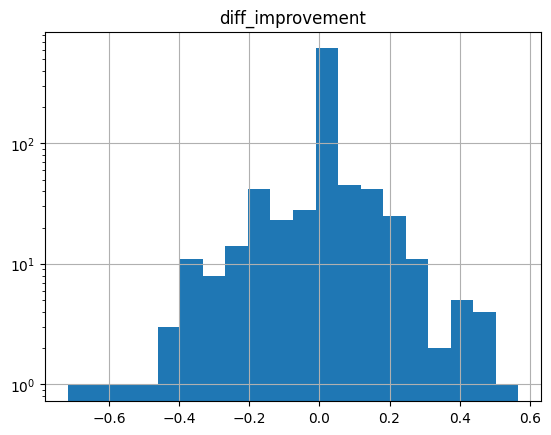

In [19]:
eval.hist(column="diff_improvement", bins=20, log=[True, False])

##### Overall Improvement

In [20]:
ndcg_cut_5_all = eval[['ndcg_without_qe', 'ndcg_with_qe']].mean()
print(f"diff_improvement: {ndcg_cut_5_all['ndcg_with_qe'] - ndcg_cut_5_all['ndcg_without_qe']}")

diff_improvement: 0.000526406048693695


##### Improvement for short and long queries

In [21]:
# average diff_improvement
eval[["is_long", "diff_improvement"]].groupby("is_long").mean()

,diff_improvement
is_long,
False,-0.008116
True,0.009904


### Hypothesentest

##### Hypothesen:
1. Die Differenz der Effektivität (ndcg) zwischen Retrieval ohne query expansion und mit query expansion bei kleinen Anfragen signifikant unterscheidet signifikant (Signifikanzlevel von 5%).
2. **Die Differenz der Effektivität (ndcg) zwischen Retrieval ohne query expansion und mit query expansion ist bei kleinen Anfragen signifikant größer als bei großen Anfragen mit Signifikanzlevel von 5%.**
3. Die Differenz der Effektivität (ndcg) zwischen Retrieval ohne query expansion und mit query expansion ist bei kleinen Anfragen signifikant kleiner als bei großen Anfragen mit Signifikanzlevel von 5%.

In [22]:
# necessary Data
short_improvement = list(eval[eval["is_long"] == False]["diff_improvement"])
long_improvement = list(eval[eval["is_long"] == True]["diff_improvement"])
print(f"short_improvement: {str(short_improvement)[:100]}...")
print(f"long_improvement: {str(long_improvement)[:100]}...")


short_improvement: [0.0, -0.35123899361230887, -0.2640681225725909, 0.0, 0.0, -0.38685280723454163, 0.12355844355602613...
long_improvement: [0.0, 0.0, 0.0, 0.0, -0.22629438553091674, 0.0, 0.0, 0.38685280723454163, 0.0, 0.12663167705327652, ...


In [55]:
# Perform a two-sample t-test

ttest_results = pd.DataFrame([
    ["Two-sided", *stats.ttest_ind(short_improvement, long_improvement), 0.05],
    ["One-sided (greater)", *stats.ttest_ind(short_improvement, long_improvement, alternative="greater"), 0.025],
    ["One-sided (less)", *stats.ttest_ind(short_improvement, long_improvement, alternative="less"), 0.025]], 
    columns=["T-Test", "T-statistic", "P-value", "necessary significance"], 
    index=["Hypothesis 1", "Hypothesis 2", "Hypothesis 3"])
# From https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html:
# This is a test for the null hypothesis that 2 independent samples have identical 
# average (expected) values. This test assumes that the populations have identical 
# variances by default.

ttest_results["accepted"] = ttest_results["P-value"] < ttest_results["necessary significance"]

ttest_results

,T-Test,T-statistic,P-value,necessary significance,accepted
Hypothesis 1,Two-sided,-2.272347,0.023306,0.050,True
Hypothesis 2,One-sided (greater),-2.272347,0.988347,0.025,False
Hypothesis 3,One-sided (less),-2.272347,0.011653,0.025,True


In [ ]:
# TODO print to somewhere where we can read it